<a href="https://colab.research.google.com/github/GorokhovSemyon/BinaryTextClassification/blob/main/CompareLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сравнение предобученных LLM моделей

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F839487%2F1433072%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240602%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240602T163223Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6a83a795ebf4419056208743632dde1c32aafbcf08e2864772b517d9232ab4b22dabf83cc94361d52afe5a11449c08ae780c63317f6699f07fdb509afa31ff3514e509be06d6622c819395f5a5a6d43df0203b702f073e75466f3795ea7ba1aa90552963be8f7d58535469cc292ce16e0f0542a5b6666b04817bbe495c00289fadee524a401cfc39c4707eff01307c216d86e11cac7d2f78bca01d3b3d87266c2848fb53f66d2b6f4a02d83b726561674f81a5ffd8c04ed17a7deb3c52d59cbbd673da2884f7579ac5f309b7d0bd9d38b3f662d96020c41f2818a8c787779bca504328744fb9ad42ae3becc986070fd966d48fec6e1f1d152c7a40fc5f68ddcb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6235359 bytes downloaded
Downloaded and uncompressed: reviews
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

In [3]:
import torch
import torch.nn as nn

from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_

In [4]:
import transformers
from transformers import BertForSequenceClassification, BertTokenizer

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [6]:
def free_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [7]:
reviews = pd.read_csv('/kaggle/input/reviews/reviews.csv', sep='\t')
reviews.drop_duplicates(subset=['review'], inplace=True)
reviews.head(10)

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative
5,Очень глубокие проймы,negative
6,Я недовольна заказом.Я вот одного не понимаю п...,negative
7,"заказала размер s на от 64,об 94,начнем с того...",negative
8,Заказ я сделала в июле. С тех пор посылка отсл...,negative
9,Ужасное качество товара!,negative


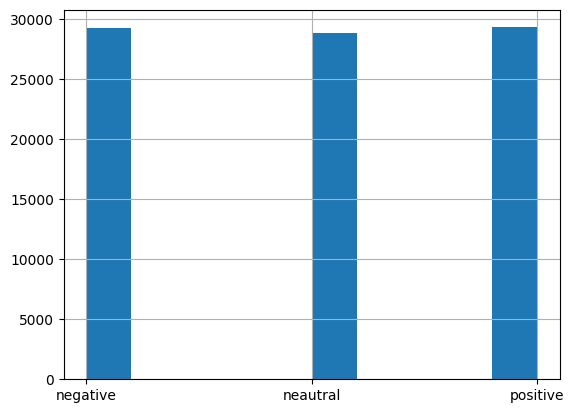

In [8]:
reviews.sentiment.hist()
plt.show()

In [9]:
sentiment_map = {
    'negative': 0,
    'neautral': 1,
    'positive': 2
}

In [10]:
reviews.sentiment = reviews.sentiment.apply(lambda x: sentiment_map[x])
reviews.head(10)

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,0
1,"Товар отдали другому человеку, я не получила п...",0
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",0
3,"товар не пришел, продавец продлил защиту без м...",0
4,"Кофточка голая синтетика, носить не возможно.",0
5,Очень глубокие проймы,0
6,Я недовольна заказом.Я вот одного не понимаю п...,0
7,"заказала размер s на от 64,об 94,начнем с того...",0
8,Заказ я сделала в июле. С тех пор посылка отсл...,0
9,Ужасное качество товара!,0


In [11]:
reviews_sample = reviews.sample(frac=0.15, replace=True, random_state=42)
reviews_sample.shape

(13098, 2)

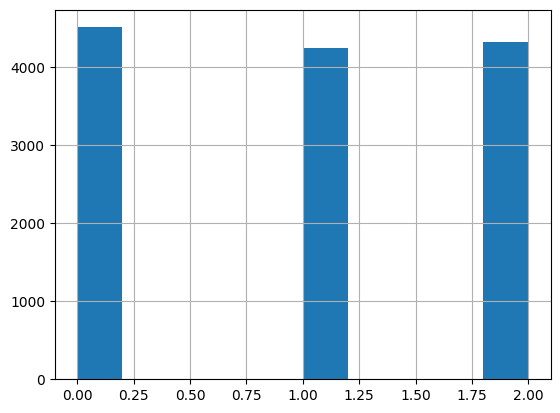

In [12]:
reviews_sample.sentiment.hist()
plt.show()

In [13]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

# Оценка модели Souvikcmsa/BERT_sentiment_analysis

In [ ]:
pretrained_model_name_or_path = 'Souvikcmsa/BERT_sentiment_analysis'

In [ ]:
num_labels = reviews.sentiment.nunique()
num_labels

3

In [ ]:
model = BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path,
                                                      num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/944 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
model = model.to(device)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
embedding_parameters = [param for name, param in model.named_parameters()
                        if 'classifier' not in name]

In [ ]:
for param in embedding_parameters:
    param.requires_grad = False

In [ ]:
X = reviews_sample.review
y = reviews_sample.sentiment

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tokenizer.pad_token_id = 0
print(tokenizer.pad_token)

[PAD]


In [ ]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, X, y, tokenizer=None, num_labels=3):
        self.X = tokenizer(X.tolist(),
                           truncation=True,
                           padding=True,
                           return_tensors="pt",
                           max_length=512).to(device)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.int64).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X.input_ids[idx], self.X.attention_mask[idx], self.y[idx]

In [ ]:
train_dataset = SentimentAnalysisDataset(X_train, y_train, tokenizer)
test_dataset = SentimentAnalysisDataset(X_test, y_test, tokenizer)

In [ ]:
batch_size = 32
num_epochs = 5

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
optimizer = AdamW(model.classifier.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
def evaluate_model(model, data_loader):
    ground_truth = []
    predictions = []

    model.eval()
    for input_ids, attention_mask, labels in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, indices = torch.max(outputs.logits, 1)
        predictions.extend(indices.tolist())
        ground_truth.extend(labels.tolist())
        del input_ids
        del attention_mask
        del labels
        del outputs
        del indices
        free_memory()
    accuracy = accuracy_score(ground_truth, predictions)
    f1 = f1_score(ground_truth, predictions, average='macro')
    del predictions
    del ground_truth
    free_memory()
    return accuracy, f1

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs,
                step_size=1, gamma=0.5):
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    loss_history = []
    train_history = []

    for epoch in range(num_epochs):
        model.train()

        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (input_ids, attention_mask, y) in enumerate(train_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            y = y.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            #logits = torch.mean(outputs.logits, dim=1)
            optimizer.zero_grad()
            loss = criterion(outputs.logits, y)
            loss.backward()
            clip_grad_norm_(model.classifier.parameters(), 1.0)
            optimizer.step()

            _, indices = torch.max(outputs.logits, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            loss_accum += loss

            del outputs
            del indices
            del input_ids
            del attention_mask
            del y
            free_memory()

        scheduler.step()
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)

        free_memory()

        print("Average loss: %f, Train accuracy: %f" % (ave_loss, train_accuracy))

    return loss_history, train_history

In [ ]:
loss_history, train_history = train_model(model,
                                          train_loader,
                                          criterion,
                                          optimizer, num_epochs)

Average loss: 1.226783, Train accuracy: 0.391869
Average loss: 1.111254, Train accuracy: 0.425654
Average loss: 1.080327, Train accuracy: 0.450277
Average loss: 1.042154, Train accuracy: 0.457244
Average loss: 1.027286, Train accuracy: 0.464974


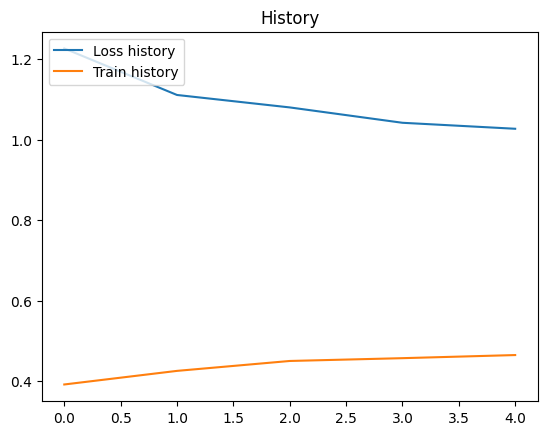

In [ ]:
plt.title("History")
plt.plot(loss_history, label="Loss history")
plt.plot(train_history, label="Train history")
plt.legend(loc="upper left")
plt.show()

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
accuracy, f1 = evaluate_model(model, test_loader)
print(f"Test accuracy is {accuracy}")
print(f"Test f1 score is {f1}")

Test accuracy is 0.5038167938931297
Test f1 score is 0.48103600343700625


In [ ]:
torch.save(model, 'BERT_sentiment_analysis.pth')

# Оценка модели DeepPavlov/rubert-base-cased

In [ ]:
pretrained_model_name_or_path = 'DeepPavlov/rubert-base-cased'

In [ ]:
num_labels = reviews.sentiment.nunique()
num_labels

3

In [ ]:
model = BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path,
                                                      num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
model = model.to(device)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
embedding_parameters = [param for name, param in model.named_parameters()
                        if 'classifier' not in name]

In [ ]:
for param in embedding_parameters:
    param.requires_grad = False

In [ ]:
X = reviews_sample.review
y = reviews_sample.sentiment

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tokenizer.pad_token_id = 0
print(tokenizer.pad_token)

[PAD]


In [ ]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, X, y, tokenizer=None, num_labels=3):
        self.X = tokenizer(X.tolist(),
                           truncation=True,
                           padding=True,
                           return_tensors="pt",
                           max_length=512).to(device)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.int64).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X.input_ids[idx], self.X.attention_mask[idx], self.y[idx]

In [ ]:
train_dataset = SentimentAnalysisDataset(X_train, y_train, tokenizer)
test_dataset = SentimentAnalysisDataset(X_test, y_test, tokenizer)

free_memory()

In [ ]:
batch_size = 32
num_epochs = 15

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
optimizer = AdamW(model.classifier.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
def evaluate_model(model, data_loader):
    ground_truth = []
    predictions = []

    model.eval()
    for input_ids, attention_mask, labels in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, indices = torch.max(outputs.logits, 1)
        predictions.extend(indices.tolist())
        ground_truth.extend(labels.tolist())
        del input_ids
        del attention_mask
        del labels
        del outputs
        del indices
        free_memory()
    accuracy = accuracy_score(ground_truth, predictions)
    f1 = f1_score(ground_truth, predictions, average='macro')
    del predictions
    del ground_truth
    free_memory()
    return accuracy, f1

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs,
                step_size=1, gamma=0.5):
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    loss_history = []
    train_history = []

    for epoch in range(num_epochs):
        model.train()

        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (input_ids, attention_mask, y) in enumerate(train_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            y = y.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            #logits = torch.mean(outputs.logits, dim=1)
            optimizer.zero_grad()
            loss = criterion(outputs.logits, y)
            loss.backward()
            clip_grad_norm_(model.classifier.parameters(), 1.0)
            optimizer.step()

            _, indices = torch.max(outputs.logits, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            loss_accum += loss

            del outputs
            del indices
            del input_ids
            del attention_mask
            del y
            free_memory()

        scheduler.step()
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)

        free_memory()

        print("Average loss: %f, Train accuracy: %f" % (ave_loss, train_accuracy))

    return loss_history, train_history

In [ ]:
loss_history, train_history = train_model(model,
                                          train_loader,
                                          criterion,
                                          optimizer, num_epochs)

Average loss: 0.982852, Train accuracy: 0.532067
Average loss: 0.890906, Train accuracy: 0.587135
Average loss: 0.870181, Train accuracy: 0.603359
Average loss: 0.851635, Train accuracy: 0.608609
Average loss: 0.852997, Train accuracy: 0.613380
Average loss: 0.848770, Train accuracy: 0.610231
Average loss: 0.845286, Train accuracy: 0.624356
Average loss: 0.852455, Train accuracy: 0.615671
Average loss: 0.841322, Train accuracy: 0.620347
Average loss: 0.849017, Train accuracy: 0.619202
Average loss: 0.846768, Train accuracy: 0.618916
Average loss: 0.842629, Train accuracy: 0.619393
Average loss: 0.845835, Train accuracy: 0.620443
Average loss: 0.841766, Train accuracy: 0.617675
Average loss: 0.847348, Train accuracy: 0.620634


In [ ]:
free_memory()

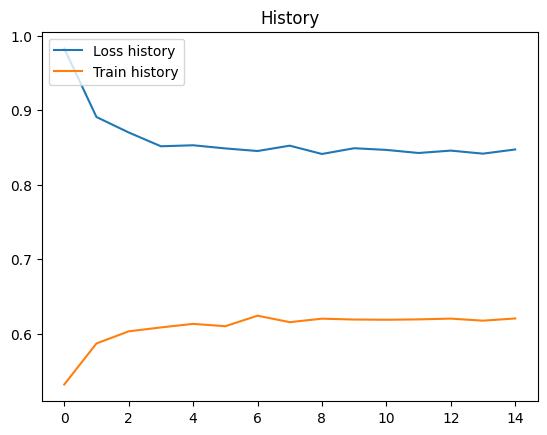

In [ ]:
plt.title("History")
plt.plot(loss_history, label="Loss history")
plt.plot(train_history, label="Train history")
plt.legend(loc="upper left")
plt.show()

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
accuracy, f1 = evaluate_model(model, test_loader)
print(f"Test accuracy is {accuracy}")
print(f"Test f1 score is {f1}")

Test accuracy is 0.6469465648854962
Test f1 score is 0.6425140056378605


In [ ]:
torch.save(model, 'st_rubert-sentiment-classifier.pth')

# Оценка модели s-nlp/russian_toxicity_classifier

In [14]:
pretrained_model_name_or_path = 's-nlp/russian_toxicity_classifier'

In [15]:
num_labels = reviews.sentiment.nunique()
num_labels

2

In [16]:
model = BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path,
                                                      num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [17]:
model = model.to(device)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [18]:
embedding_parameters = [param for name, param in model.named_parameters()
                        if 'classifier' not in name]

In [19]:
for param in embedding_parameters:
    param.requires_grad = False

In [20]:
X = reviews_sample.review
y = reviews_sample.sentiment

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
tokenizer.pad_token_id = 0
print(tokenizer.pad_token)

[PAD]


In [23]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, X, y, tokenizer=None, num_labels=3):
        self.X = tokenizer(X.tolist(),
                           truncation=True,
                           padding=True,
                           return_tensors="pt",
                           max_length=512).to(device)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.int64).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X.input_ids[idx], self.X.attention_mask[idx], self.y[idx]

In [24]:
train_dataset = SentimentAnalysisDataset(X_train, y_train, tokenizer)
test_dataset = SentimentAnalysisDataset(X_test, y_test, tokenizer)

free_memory()

In [25]:
batch_size = 32
num_epochs = 5

In [26]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [27]:
optimizer = AdamW(model.classifier.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [28]:
def evaluate_model(model, data_loader):
    ground_truth = []
    predictions = []

    model.eval()
    for input_ids, attention_mask, labels in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, indices = torch.max(outputs.logits, 1)
        predictions.extend(indices.tolist())
        ground_truth.extend(labels.tolist())
        del input_ids
        del attention_mask
        del labels
        del outputs
        del indices
        free_memory()
    accuracy = accuracy_score(ground_truth, predictions)
    f1 = f1_score(ground_truth, predictions, average='macro')
    del predictions
    del ground_truth
    free_memory()
    return accuracy, f1

In [29]:
def train_model(model, train_loader, criterion, optimizer, num_epochs,
                step_size=1, gamma=0.5):
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    loss_history = []
    train_history = []

    for epoch in range(num_epochs):
        model.train()

        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (input_ids, attention_mask, y) in enumerate(train_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            y = y.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            #logits = torch.mean(outputs.logits, dim=1)
            optimizer.zero_grad()
            loss = criterion(outputs.logits, y)
            loss.backward()
            clip_grad_norm_(model.classifier.parameters(), 1.0)
            optimizer.step()

            _, indices = torch.max(outputs.logits, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            loss_accum += loss

            del outputs
            del indices
            del input_ids
            del attention_mask
            del y
            free_memory()

        scheduler.step()
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)

        free_memory()

        print("Average loss: %f, Train accuracy: %f" % (ave_loss, train_accuracy))

    return loss_history, train_history

In [ ]:
loss_history, train_history = train_model(model,
                                          train_loader,
                                          criterion,
                                          optimizer, num_epochs)

Average loss: 1.226783, Train accuracy: 0.391869
Average loss: 1.111254, Train accuracy: 0.425654
Average loss: 1.080327, Train accuracy: 0.450277
Average loss: 1.042154, Train accuracy: 0.457244
Average loss: 1.027286, Train accuracy: 0.464974


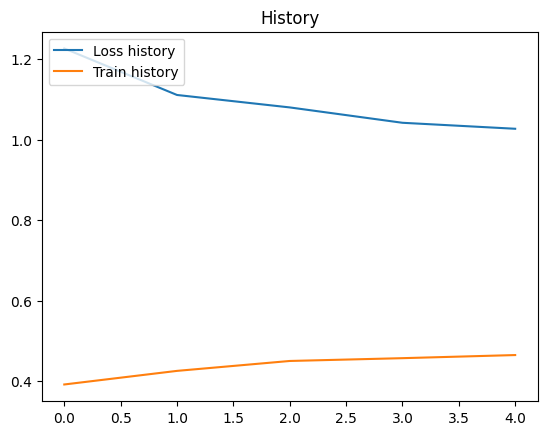

In [ ]:
plt.title("History")
plt.plot(loss_history, label="Loss history")
plt.plot(train_history, label="Train history")
plt.legend(loc="upper left")
plt.show()

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
accuracy, f1 = evaluate_model(model, test_loader)
print(f"Test accuracy is {accuracy}")
print(f"Test f1 score is {f1}")

Test accuracy is 0.5038167938931297
Test f1 score is 0.48103600343700625


In [ ]:
free_memory()

In [ ]:
torch.save(model, 'russian_toxicity_classifier.pth')

# Сравнение результатов и выводы

Исходя из результатов тестирования моделей на одном датасете можно сделать вывод, что наиболее подходящая модель - это та, которая имеет высокую среднюю точность, низкие потери при обучении и высокий F1-score. Если модель сильно отличается по одной из этих метрик, это может указывать на проблемы, такие как переобучение или недообучение, и потребовать дальнейшей настройки или дообучения. Из протестированных лучшая - DeepPavlov/rubert-base-cased.

Получая данные параметры для модели и сравнивая их можно делать выводы о лучшей модели под задачу. Последняя модель, конечно отличается от остальных тем, что разделяет на два класса и скорее всего делает это точнее, но тут зависит от задачи, стоит ли нам сделать упор на точность, либо же на определение именно трёх классов отзывов.

Для задачи классификации всего на три класса достаточно вышеуказанных метрик, но если задача становится более специализированной и сложной, то может потребоваться разработка собственных метрик, которые полнее отражают результаты работы.